In [1]:
!pip install matplotlib scikit-image

import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from skimage.io import imread
from skimage.color import rgb2gray
from skimage import exposure
from skimage import color
from skimage.feature import hog
from skimage.filters import threshold_otsu
from skimage.filters import threshold_local
from skimage.morphology import binary_erosion
from skimage.measure import regionprops, find_contours

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score


2023-07-25 08:33:33.231587: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-25 08:33:33.319221: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load the image paths and labels from the DataFrame
df = pd.read_csv('Dataset/cards.csv')

# For column names that contain space, replace the space with an underscore
df.columns = [c.replace(' ', '_') for c in df.columns]

# Add suits column
df['suit'] = df['labels'].str.split().str[-1]

# Remove rows with jokers
df = df[~df['suit'].str.contains('joker', case=False)]

# Remove unwanted columns
df = df.drop(columns = ['data_set'])
df = df.drop(columns = ['class_index'])
df = df.drop(columns = ['labels'])
df = df.drop(columns = ['card_type'])

# Add folder name to the filepath
df['filepaths'] = df['filepaths'].apply(lambda x: 'Dataset/' + x)
df.head()

,filepaths,suit
0,Dataset/train/ace of clubs/001.jpg,clubs
1,Dataset/train/ace of clubs/002.jpg,clubs
2,Dataset/train/ace of clubs/003.jpg,clubs
3,Dataset/train/ace of clubs/004.jpg,clubs
4,Dataset/train/ace of clubs/005.jpg,clubs


In [3]:
# Split dataframe into train and test sets, stratified by the 'suit' column
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['suit'], random_state=42)

# Split train set into train and validation sets, stratified by the 'suit' column
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['suit'], random_state=42)

# Check class distribution in the train, validation, and test sets
train_class_distribution = train_df['suit'].value_counts(normalize=True)
val_class_distribution = val_df['suit'].value_counts(normalize=True)
test_class_distribution = test_df['suit'].value_counts(normalize=True)

print("Train Set - Class Distribution:")
print(train_class_distribution)

print("Validation Set - Class Distribution:")
print(val_class_distribution)

print("Test Set - Class Distribution:")
print(test_class_distribution)

Train Set - Class Distribution:
spades      0.269171
hearts      0.246010
diamonds    0.243675
clubs       0.241144
Name: suit, dtype: float64
Validation Set - Class Distribution:
spades      0.269261
hearts      0.245914
diamonds    0.243580
clubs       0.241245
Name: suit, dtype: float64
Test Set - Class Distribution:
spades      0.268991
hearts      0.245953
diamonds    0.244085
clubs       0.240971
Name: suit, dtype: float64


## Augment Images

In [4]:
# Initialize data generator class

train_data_generator = ImageDataGenerator(
    rescale = 1/255.0,
    rotation_range= 45,
    zoom_range= 0.2,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range= 0.2,
    horizontal_flip=True,
    vertical_flip=True
)

test_data_generator = ImageDataGenerator(rescale = 1/255.0)

# Create data generators for train, validation, and test
batch_size = 32

train_generator = train_data_generator.flow_from_dataframe(
    dataframe = train_df,
    x_col = 'filepaths',
    y_col = 'suit',
    target_size = (224,224),
    batch_size = batch_size,
    class_mode = 'categorical'
)

valid_generator = train_data_generator.flow_from_dataframe(
    dataframe = val_df,
    x_col = 'filepaths',
    y_col = 'suit',
    target_size = (224,224),
    batch_size = batch_size,
    class_mode = 'categorical'
)


test_generator = test_data_generator.flow_from_dataframe(
    dataframe = test_df,
    x_col = 'filepaths',
    y_col = 'suit',
    target_size = (224,224),
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = False,
)


Found 5138 validated image filenames belonging to 4 classes.
Found 1285 validated image filenames belonging to 4 classes.
Found 1606 validated image filenames belonging to 4 classes.


In [13]:
# Load and preprocess the images
def load_and_preprocess_image(filepath):
    image = cv2.imread(filepath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    return image

# Convert to image to grayscale
def convert_to_grayscale(images):
    gray_images = np.array([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in images])
    gray_images = gray_images.astype(np.uint8)
    return gray_images

# Extract HOG feature vectors
def extract_hog_features(images):
    hog_features = []
    for img in images:
        hog_feature = hog(img, pixels_per_cell=(8, 8), cells_per_block=(2, 2))
        hog_features.append(hog_feature)
    return np.array(hog_features)

In [14]:
# Load data from the generators and extract HOG features
train_images = np.array([load_and_preprocess_image(train_generator.filepaths[i]) for i in range(len(train_generator.filenames))])
valid_images = np.array([load_and_preprocess_image(valid_generator.filepaths[j]) for j in range(len(valid_generator.filenames))])
test_images = np.array([load_and_preprocess_image(test_generator.filepaths[k]) for k in range(len(test_generator.filenames))])

# Convert to grayscale
train_gray_images = convert_to_grayscale(train_images)
valid_gray_images = convert_to_grayscale(valid_images)
test_gray_images = convert_to_grayscale(test_images)

# Extract HOG feature vectors
train_hog_features = extract_hog_features(train_gray_images)
valid_hog_features = extract_hog_features(valid_gray_images)
test_hog_features = extract_hog_features(test_gray_images)

# Convert labels to arrays and one-hot encode 
train_labels = to_categorical(train_generator.labels, num_classes=4)
valid_labels = to_categorical(valid_generator.labels, num_classes=4)
test_labels = to_categorical(test_generator.labels, num_classes=4)


In [41]:
# SVM using the train HOG features
num_classes = 4

model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(train_hog_features.shape[1],)))
model.add(Dropout(0.05))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.05))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

In [42]:
# Create and train the SVM classifier
svm_classifier = SVC(kernel='linear', C=1.0)
svm_classifier.fit(train_hog_features, train_generator.labels)


SVC(kernel='linear')

In [43]:
# Make predictions on the validation set
valid_predictions = svm_classifier.predict(valid_hog_features)

# Calculate validation accuracy
valid_accuracy = accuracy_score(valid_generator.labels, valid_predictions)
print("Validation Accuracy:", valid_accuracy)

# Make predictions on the test set
test_predictions = svm_classifier.predict(test_hog_features)

# Calculate test accuracy
test_accuracy = accuracy_score(test_generator.labels, test_predictions)
print("Test Accuracy:", test_accuracy)

Validation Accuracy: 0.7673151750972763
Test Accuracy: 0.7615193026151931


In [46]:
# Get the class names from the generator (assuming it has the 'class_indices' attribute)
class_names = list(test_generator.class_indices.keys())

# Calculate classification report for validation set
valid_report = classification_report(valid_generator.labels, valid_predictions, target_names=class_names)
print("Validation Classification Report:\n", valid_report)

# Calculate classification report for test set
test_report = classification_report(test_generator.labels, test_predictions, target_names=class_names)
print("Test Classification Report:\n", test_report)

Validation Classification Report:
               precision    recall  f1-score   support

       clubs       0.74      0.77      0.76       310
    diamonds       0.80      0.78      0.79       313
      hearts       0.82      0.78      0.80       316
      spades       0.72      0.73      0.73       346

    accuracy                           0.77      1285
   macro avg       0.77      0.77      0.77      1285
weighted avg       0.77      0.77      0.77      1285

Test Classification Report:
               precision    recall  f1-score   support

       clubs       0.73      0.80      0.76       387
    diamonds       0.77      0.76      0.76       392
      hearts       0.79      0.75      0.77       395
      spades       0.76      0.74      0.75       432

    accuracy                           0.76      1606
   macro avg       0.76      0.76      0.76      1606
weighted avg       0.76      0.76      0.76      1606



## Sample Images

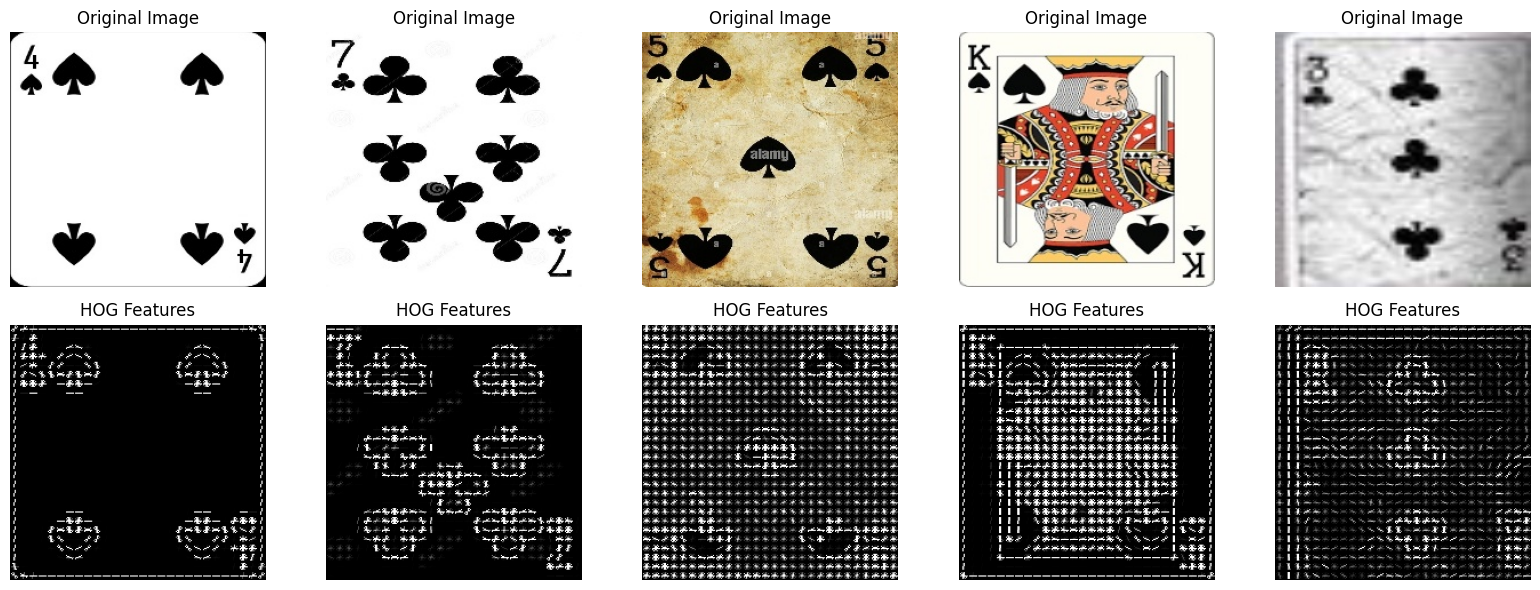

In [49]:
sample_filepaths = train_generator.filepaths[:5] 

# Load and preprocess the sample images
sample_images = np.array([load_and_preprocess_image(filepath) for filepath in sample_filepaths])

# Convert the images to grayscale
sample_gray_images = convert_to_grayscale(sample_images)

# Extract HOG features for the sample images
sample_hog_features = extract_hog_features(sample_gray_images)

# Display the sample HOG features
plt.figure(figsize=(16, 6))
for i in range(len(sample_images)):
    plt.subplot(2, len(sample_images), i + 1)
    plt.imshow(sample_images[i])
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(2, len(sample_images), len(sample_images) + i + 1)
    hog_image = hog(sample_gray_images[i], pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)[1]
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
    plt.imshow(hog_image_rescaled, cmap='gray')
    plt.title('HOG Features')
    plt.axis('off')

plt.tight_layout()
plt.show()